In [1]:

import colour_scheme as cs
import importlib
importlib.reload(cs)

import scanpy as sc
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=250, format='pdf')
import numpy as np
import pandas as pd
from scipy import io
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from pathlib import Path

%matplotlib inline

path_fig = ''

In [2]:
adata = sc.read_h5ad(Path(path_data)/'exp1_processed_5_1.h5ad')
adata = adata[adata.obs.cell_line.isin(['H1', 'H9', 'WTC', 'WIBJ2'])].copy()
adata


AnnData object with n_obs × n_vars = 209902 × 4347
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample', 'lib', 'original_name', 'condition\xa0_x', 'condition\xa0_y', 'condition_name_full', 'cell_line_1', 'cell_line_2', 'batch', 'medium', 'morphogen', 'morphogen_full', 'Batch_Medium', 'medium_morphogen', 'leiden', 'cell_class_v1', 'region_v1', 'fullname_v1', 'cell_line_pool', 'line_medium', 'iPSC_prob_max', 'iPSC_best_singlet', 'ESC_prob_max', 'ESC_best_singlet', 'cell_line', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.1', 'best_class', 'best_score_class', 'best_NT', 'best_score_NT', 'best_region', 'fullname_v3', 'doublet_score', 'predicted_doublet', 'fullname_v4', 'fullname_v5'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'RNA_snn_res.1_colors', 'batch_colors', 'best_NT_colors', 'best_class_colors', 'bes

In [3]:
adata.obs['line_morphogen_batch'] = adata.obs.medium_morphogen.astype(str) + '_' + adata.obs.cell_line.astype(str) + '_' + adata.obs.batch.astype(str) 
adata.obs['line_morphogen'] = adata.obs.cell_line.astype(str) + '_' + adata.obs.medium_morphogen.astype(str)




In [4]:
ap_dv = pd.read_csv(Path(path_data)/'meta_ap_parse_01_12.tsv', sep="\t")
ap_dv.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,sample,lib,original_name,condition _x,condition _y,condition_name_full,...,best_class,best_score_class,best_NT,best_score_NT,best_region,fullname_v3,fullname_v4,newDV_glmnet,AP_glmnet,AP_ZH
0,2600,4652,68,1.461737,1,s1,01_01_21__s1,1,1,B1_NIM_Ctrl,...,Radial glia,2.669640,Non_neural,2.887611,Subcortex,Telencephalic Progenitors,Telencephalic Progenitors,2.385578,1.517928,1.199372
1,1617,2499,54,2.160864,1,s1,01_01_23__s1,1,1,B1_NIM_Ctrl,...,Radial glia,1.041591,Non_neural,1.105426,Subcortex,Telencephalic Progenitors,Telencephalic Progenitors,-0.999879,3.801428,0.399517
2,5209,15899,187,1.176175,1,s1,01_01_26__s1,1,1,B1_NIM_Ctrl,...,Radial glia,2.533137,Non_neural,2.533137,Subcortex,Telencephalic Progenitors,Telencephalic Progenitors,-0.751190,5.308215,0.567229
3,3877,9904,149,1.504443,1,s1,01_01_31__s1,1,1,B1_NIM_Ctrl,...,Radial glia,1.854231,Non_neural,1.854231,Subcortex,Telencephalic Progenitors,Telencephalic Progenitors,-0.182261,3.370040,0.642513
4,4375,9521,165,1.733011,1,s1,01_01_38__s1,1,1,B1_NIM_Ctrl,...,Radial glia,0.438574,Non_neural,0.450696,Subcortex,Telencephalic Progenitors,Telencephalic Progenitors,-0.775611,0.242396,1.561182


In [5]:
df = pd.merge(adata.obs, ap_dv[['original_name', 'newDV_glmnet', 'AP_glmnet', 'AP_ZH']], on='original_name', how='left')
df.fullname_v5.unique().tolist()
df = df[df.fullname_v5.isin(['Telencephalic Progenitors',
 'Retinal Progenitors',
 'Hindbrain Progenitors',
 
 
 'Hypothalamic Progenitors',
 
 'Neuroectoderm/Neuroepithelium',
 'Spinal Cord Progenitors',
 'Cortical Hem/Diencephalon',
 'Midbrain Progenitors',
 
 'Floor Plate'])].copy()


In [6]:
aggr = pd.DataFrame(df[['line_morphogen', 'newDV_glmnet','AP_ZH']].groupby("line_morphogen").mean()).copy()
aggr.head()

,newDV_glmnet,AP_ZH
line_morphogen,,
H1_CHIR_A_NIM,-1.696596,0.851701
H1_CHIR_A_NPM,-8.205065,2.173586
H1_CHIR_E_NPM,0.384471,3.027531
H1_CHIR_tA_NIM,-1.506441,2.100415
H1_CHIR_tA_NPM,-6.822550,3.498283


In [7]:
aggr['cell'] = aggr.index.str.split('_',n=1).str[0]
aggr['Condition_1'] = aggr.index.str.split('_',n=1).str[1]
aggr['Morphogen'] = aggr.Condition_1.str.split('_',n=1).str[0]
aggr['Medium'] = aggr.Condition_1.str[-3:]
aggr['full_morphogen'] = aggr.Condition_1.str[:-4]

aggr['cell_medium'] = aggr['cell'].astype(str) + '_' + aggr['Medium'].astype(str)
aggr

,newDV_glmnet,AP_ZH,cell,Condition_1,Morphogen,Medium,full_morphogen,cell_medium
line_morphogen,,,,,,,,
H1_CHIR_A_NIM,-1.696596,0.851701,H1,CHIR_A_NIM,CHIR,NIM,CHIR_A,H1_NIM
H1_CHIR_A_NPM,-8.205065,2.173586,H1,CHIR_A_NPM,CHIR,NPM,CHIR_A,H1_NPM
H1_CHIR_E_NPM,0.384471,3.027531,H1,CHIR_E_NPM,CHIR,NPM,CHIR_E,H1_NPM
H1_CHIR_tA_NIM,-1.506441,2.100415,H1,CHIR_tA_NIM,CHIR,NIM,CHIR_tA,H1_NIM
H1_CHIR_tA_NPM,-6.822550,3.498283,H1,CHIR_tA_NPM,CHIR,NPM,CHIR_tA,H1_NPM
...,...,...,...,...,...,...,...,...
WTC_RA_E_NPM,0.320479,2.785394,WTC,RA_E_NPM,RA,NPM,RA_E,WTC_NPM
WTC_SHH_A_NIM,-4.080476,1.129227,WTC,SHH_A_NIM,SHH,NIM,SHH_A,WTC_NIM
WTC_SHH_A_NPM,-1.644737,2.868671,WTC,SHH_A_NPM,SHH,NPM,SHH_A,WTC_NPM


## Calculate absolute AP DV score and delta to control

In [8]:

delta_dv = []
delta_ap = []
for index, row in aggr.iterrows():
    dv = row['newDV_glmnet'] - aggr[(aggr.Morphogen=='Ctrl')&(aggr.cell_medium==row.cell_medium)]['newDV_glmnet']
    delta_dv.append(dv.values[0])

    ap = row['AP_ZH'] - aggr[(aggr.Morphogen=='Ctrl')&(aggr.cell_medium==row.cell_medium)]['AP_ZH']
    delta_ap.append(ap.values[0])

aggr['delta_dv'] = delta_dv
aggr['delta_ap'] = delta_ap
aggr.full_morphogen.unique().tolist()


aggr['full_morphogen'] = aggr['full_morphogen'].astype('category')
aggr['full_morphogen']= aggr['full_morphogen'].cat.reorder_categories(['Ctrl',
 'SHH_A',
 'SHH_E',
'CHIR_A',
 'CHIR_E',
 'RA_A',
 'RA_E',
 'FGF8_late_A',
 'FGF8_late_E',
 
 'CHIR_tA',
 'CHIR_tC',
 'CHIR_tE'
 
 ])



In [ ]:
def plot_ap_dv(data, x, y, mode = None, title = None, path_save=None):
    Morphogen_full = { "Ctrl": "#000000",
    "SHH_A": "#FFC370",
    "SHH_E": "#FF990A",
    "RA_A": "#E0EB47",
    "RA_E": "#9BA512",
    "CHIR_A": "#B0D4D4",
    "CHIR_E": "#569F9E",
    "FGF8_late_A": "#C7AED6",
    "FGF8_late_E": "#8452A3",
    "CHIR_tA": "#FFB3C9",
    "CHIR_tC": "#EC5B86",
    "CHIR_tE": "#C7184C"}
    sns.set(rc={'figure.figsize':(6.75,5)})
    sns.set_style("whitegrid")
    plt.rcParams.update({
        "axes.edgecolor": "black",  # Make axes black
        "grid.color": "black",     # Make gridlines black
        "grid.linewidth": 0.3,     # Optional: Adjust gridline thickness
         "axes.linewidth": 0.3,    
    })
    
    
    sns.scatterplot(
       data = data,
       x = x,
       y = y,
       hue='full_morphogen',
       palette = Morphogen_full,
       s=100,
       alpha=0.95,
        style='cell',
        markers=['o', 's', '>', 'd'],
        edgecolor= 'black'
            #edgecolor=nim["edge_color"].values
    )
    if mode == 'delta':
        
        plt.axhline(0, linestyle=(5, (10, 3)), color='black', linewidth=1.5)
        plt.axvline(0, linestyle=(5, (10, 3)), color='black', linewidth=1.5)
   
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)

    if path_save:
        plt.tight_layout()
        plt.rcParams['pdf.fonttype'] = 42 
        plt.savefig(path_save, dpi=300)

    plt.show()


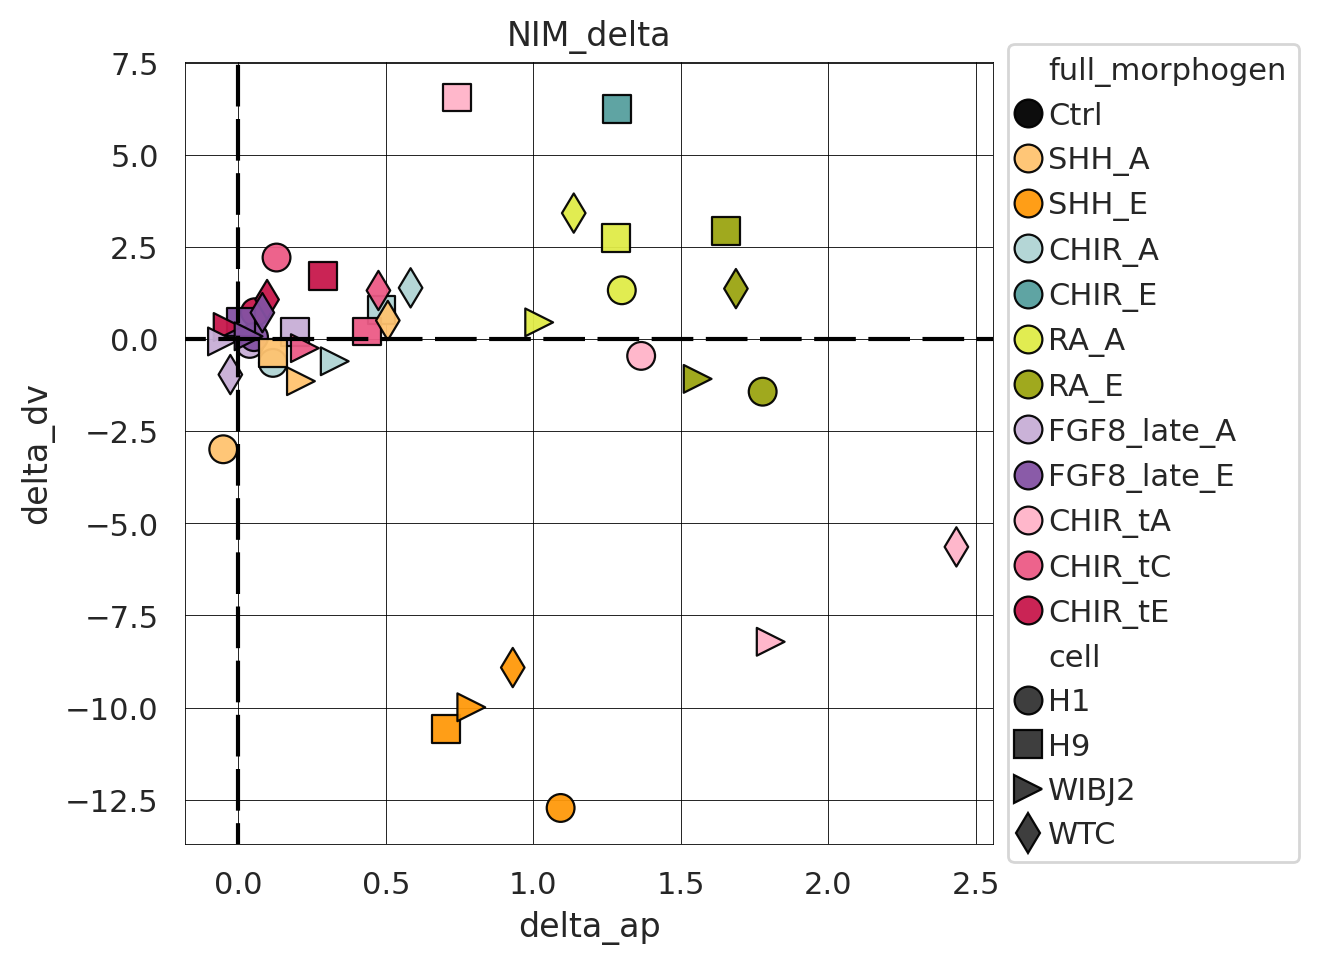

In [9]:

#NIM

nim = aggr[aggr.Medium == 'NIM'].copy()
nim = nim[nim.Morphogen !='Ctrl']


plot_ap_dv(nim, "delta_ap","delta_dv", 'delta',"NIM_delta", path_fig+"NIM_delta.pdf")


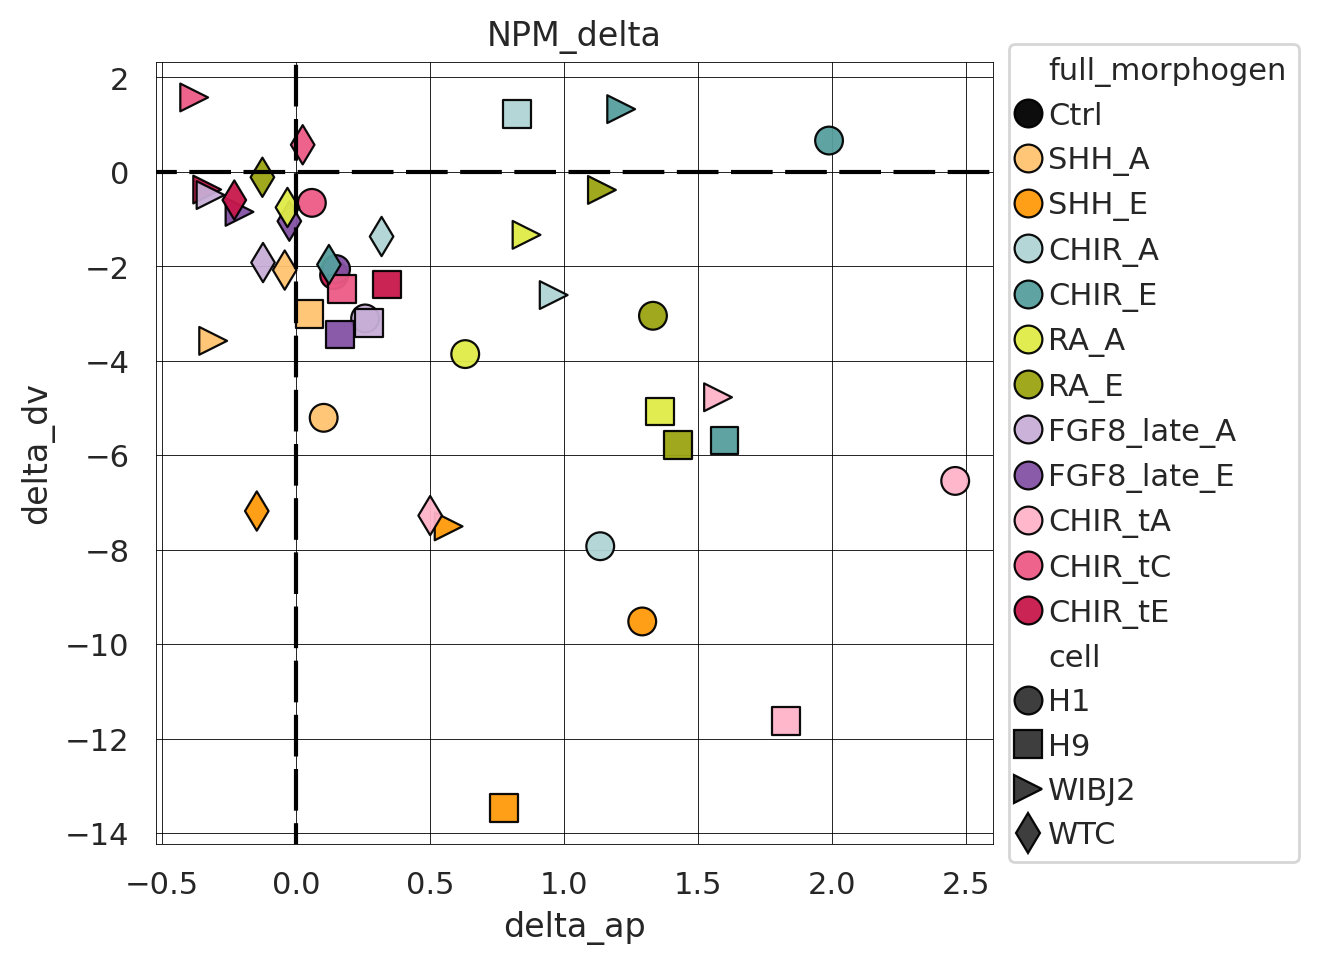

In [10]:
# NPM


npm = aggr[aggr.Medium == 'NPM'].copy()
npm = npm[npm.Morphogen !='Ctrl']


plot_ap_dv(npm, "delta_ap","delta_dv",'delta',"NPM_delta", path_fig+"NPM_delta2.pdf")


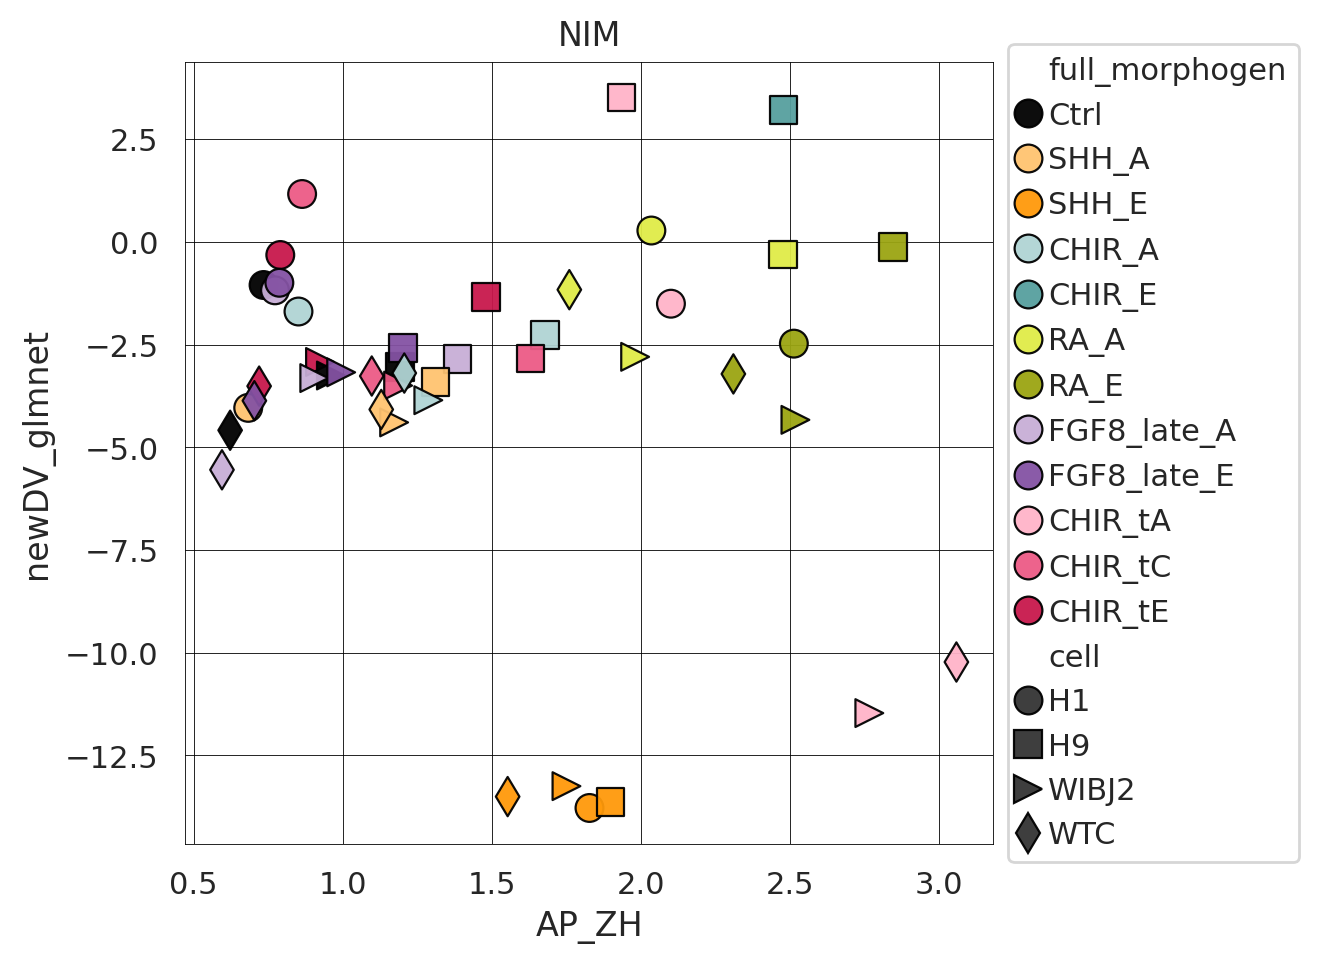

In [11]:
#### Fig. 4l ###

nim = aggr[aggr.Medium == 'NIM'].copy()
plot_ap_dv(nim, "AP_ZH","newDV_glmnet", mode = None,title="NIM", path_save=path_fig+"NIM2.pdf")


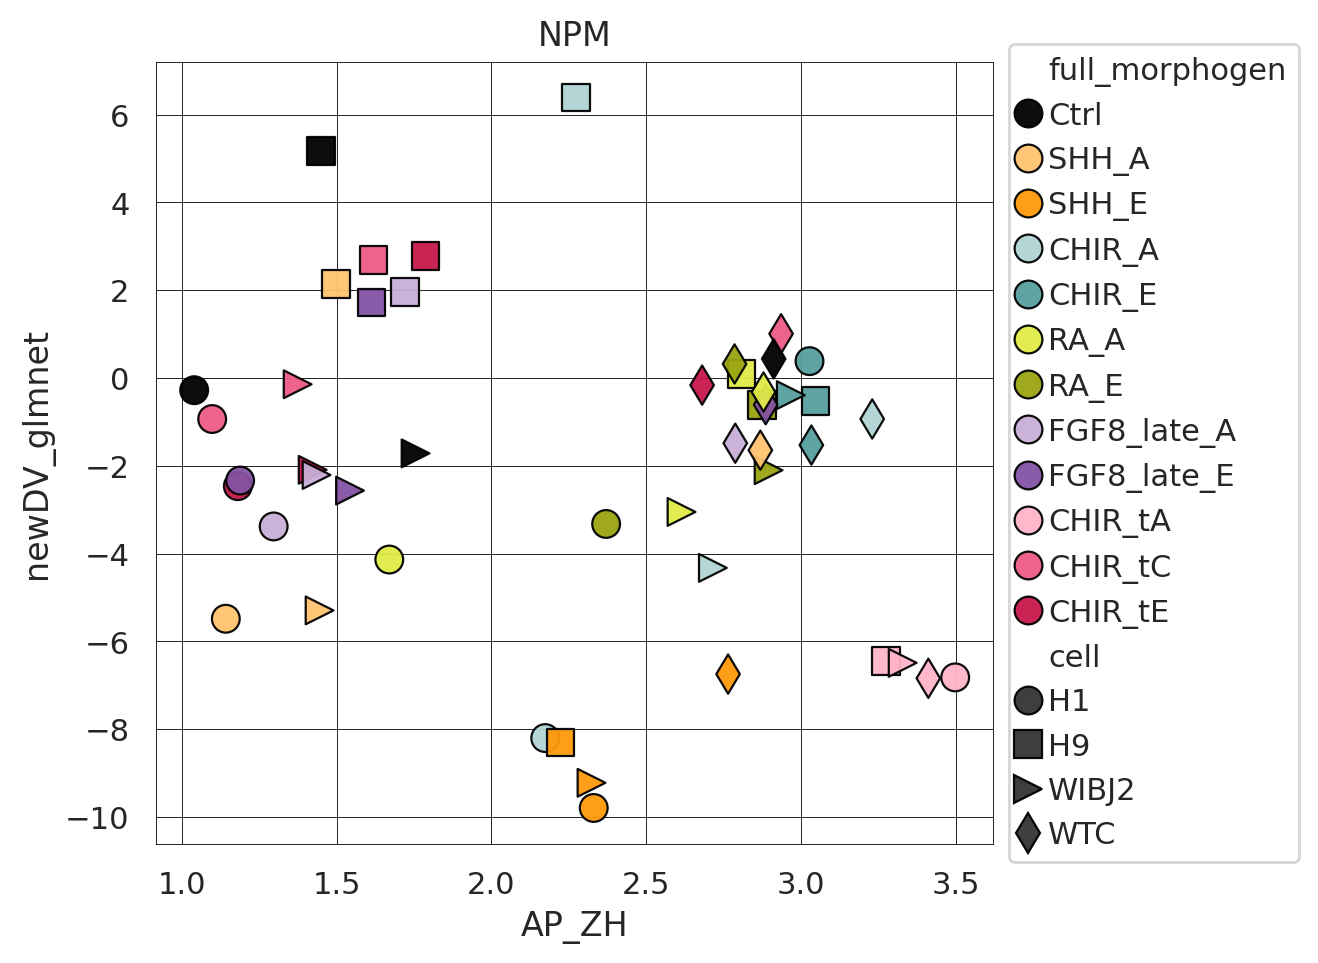

In [12]:
#### Fig. 4l ###

npm = aggr[aggr.Medium == 'NPM'].copy()
plot_ap_dv(npm, "AP_ZH","newDV_glmnet", mode = None,title="NPM", path_save=path_fig+"NPM2.pdf")
